# Sentiment analysis - Extra huggingface version


Pakin Siwatammarat

## Import library

In [80]:
import re
import torch
import pickle
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pythainlp.util import emoji_to_thai
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline
)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [81]:
warnings.filterwarnings("ignore")
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## Read data

In [51]:
with open('./data/train.txt', encoding="utf8") as f:
  train_texts = [line.strip() for line in f.readlines()]
  f.close()

with open('./data/train_label.txt', encoding="utf8") as f:
  train_labels = [line.strip() for line in f.readlines()]
  f.close()

In [52]:
with open('./data/test.txt', encoding="utf8") as f:
  test_texts = [line.strip() for line in f.readlines()]
  f.close()

with open('./data/test_label.txt', encoding="utf8") as f:
  test_labels = [line.strip() for line in f.readlines()]
  f.close()

In [53]:
# convert from list to pandas 
df = pd.DataFrame({"text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

In [54]:
df.head()

,text,label
0,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,neu
1,คะ,neu
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,neg
3,😅😅😅,neu
4,สวัสดีวันพุธ แนน อะไรนะ,neu


In [55]:
test_df.head()

,text,label
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,neg
1,ครับ #phithanbkk,neu
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,neg
3,Cf clarins 5 ขวด 2850,neu
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,neu


## Class distribution

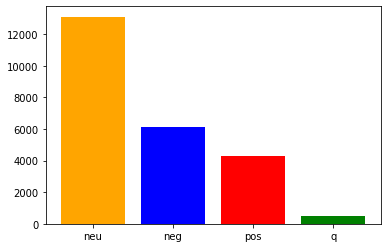

In [56]:
count  = df['label'].value_counts()
plt.bar(count.index, count.values, color=['orange', 'blue', 'red', 'green']);

In [57]:
df['label'].value_counts() / df.shape[0]

neu    0.544612
neg    0.255164
pos    0.178698
q      0.021527
Name: label, dtype: float64

## Label Encoding


In [58]:
le = preprocessing.LabelEncoder()
le.fit(df['label']);

In [59]:
df['label'] = le.transform(df['label'])
test_df['label'] = le.transform(test_df['label'])

In [60]:
label2id = dict(zip(le.classes_, range(len(le.classes_))))
label2id

{'neg': 0, 'neu': 1, 'pos': 2, 'q': 3}

In [61]:
id2label = dict(zip(range(len(le.classes_)), le.classes_))
id2label

{0: 'neg', 1: 'neu', 2: 'pos', 3: 'q'}

## Text preprocess

In [62]:
def replace_rep(text):
  def _replace_rep(m):
    c,cc = m.groups()
    return f'{c}xxrep'
  re_rep = re.compile(r'(\S)(\1{2,})')
  return re_rep.sub(_replace_rep, text)

def replace_url(text):
  URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
  return re.sub(URL_PATTERN, 'xxurl', text)

def replace_emoji(text):
  return emoji_to_thai(text, delimiters=(' ', ' '))

def replace_punctuation(text):
  punctuation = string.punctuation.replace(".", "") # remove all punctuation except . because we want to keep infomation some word such as "อ.", "จ." and etc.
  punctuation_translator = str.maketrans('', '', punctuation)
  return text.translate(punctuation_translator)

def preprocess(text):
  preprocess_text = text.lower().strip()
  preprocess_text = replace_url(preprocess_text)
  preprocess_text = replace_rep(preprocess_text)
  # preprocess_text = replace_emoji(preprocess_text)
  preprocess_text = replace_punctuation(preprocess_text)
  return preprocess_text


In [63]:
df['preprocess'] = df['text'].apply(lambda x: preprocess(x))
test_df['preprocess'] = test_df['text'].apply(lambda x: preprocess(x))

In [64]:
df.head()

,text,label,preprocess
0,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,1,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1,คะ,1,คะ
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,0,อิเหี้ยออมทำกูอยากกินเอ็มเค
3,😅😅😅,1,😅xxrep
4,สวัสดีวันพุธ แนน อะไรนะ,1,สวัสดีวันพุธ แนน อะไรนะ


In [65]:
test_df.head()

,text,label,preprocess
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...
1,ครับ #phithanbkk,1,ครับ phithanbkk
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,0,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...
3,Cf clarins 5 ขวด 2850,1,cf clarins 5 ขวด 2850
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1,ทานได้ค่ะ น้ำซุป mk ต้มมาจากหัวผักกาด ซีอิ้วขา...


## Modeling

### Define dataset class

In [17]:
class reviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
texts, labels = df['preprocess'], df['label']
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=.15, stratify=labels, random_state=13)

test_texts, test_labels = test_df['preprocess'], test_df['label']

In [19]:
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased", model_max_length=416)
model = AutoModelForSequenceClassification.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased", revision="main", num_labels=4)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

In [20]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

train_dataset = reviewDataset(train_encodings, list(train_labels))
val_dataset = reviewDataset(val_encodings, list(val_labels))
test_dataset = reviewDataset(test_encodings, list(test_labels))

In [21]:
training_args = TrainingArguments(
    output_dir="./save_weights/wangchanberta",
    overwrite_output_dir=True,
    num_train_epochs=1,              
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    logging_dir='./logs',             
    logging_steps=500,
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01,
    adam_epsilon=1e-08,
    max_grad_norm=1.0,
    evaluation_strategy="steps",
    seed=13
)

In [22]:
trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset
)
trainer.train()

***** Running training *****
  Num examples = 20453
  Num Epochs = 1
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 12
  Gradient Accumulation steps = 1
  Total optimization steps = 1705
 29%|██▉       | 500/1705 [06:49<18:17,  1.10it/s]***** Running Evaluation *****
  Num examples = 3610
  Batch size = 24


{'loss': 0.9785, 'learning_rate': 5e-05, 'epoch': 0.29}


                                                  
 29%|██▉       | 500/1705 [08:32<18:17,  1.10it/s]Saving model checkpoint to ./save_weights\checkpoint-500
Configuration saved in ./save_weights\checkpoint-500\config.json


{'eval_loss': 0.7512118816375732, 'eval_runtime': 102.4889, 'eval_samples_per_second': 35.223, 'eval_steps_per_second': 1.473, 'epoch': 0.29}


Model weights saved in ./save_weights\checkpoint-500\pytorch_model.bin
 59%|█████▊    | 1000/1705 [16:10<10:29,  1.12it/s]  ***** Running Evaluation *****
  Num examples = 3610
  Batch size = 24


{'loss': 0.7232, 'learning_rate': 2.9253112033195024e-05, 'epoch': 0.59}


                                                   
 59%|█████▊    | 1000/1705 [17:55<10:29,  1.12it/s]Saving model checkpoint to ./save_weights\checkpoint-1000
Configuration saved in ./save_weights\checkpoint-1000\config.json


{'eval_loss': 0.6572005748748779, 'eval_runtime': 104.6987, 'eval_samples_per_second': 34.48, 'eval_steps_per_second': 1.442, 'epoch': 0.59}


Model weights saved in ./save_weights\checkpoint-1000\pytorch_model.bin
 88%|████████▊ | 1500/1705 [25:40<03:09,  1.08it/s]  ***** Running Evaluation *****
  Num examples = 3610
  Batch size = 24


{'loss': 0.6338, 'learning_rate': 8.506224066390042e-06, 'epoch': 0.88}


                                                   
 88%|████████▊ | 1500/1705 [27:25<03:09,  1.08it/s]Saving model checkpoint to ./save_weights\checkpoint-1500
Configuration saved in ./save_weights\checkpoint-1500\config.json


{'eval_loss': 0.6195637583732605, 'eval_runtime': 105.216, 'eval_samples_per_second': 34.31, 'eval_steps_per_second': 1.435, 'epoch': 0.88}


Model weights saved in ./save_weights\checkpoint-1500\pytorch_model.bin
100%|██████████| 1705/1705 [30:40<00:00,  1.26it/s]  

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 1705/1705 [30:40<00:00,  1.08s/it]

{'train_runtime': 1840.0553, 'train_samples_per_second': 11.115, 'train_steps_per_second': 0.927, 'train_loss': 0.7609738794589672, 'epoch': 1.0}


TrainOutput(global_step=1705, training_loss=0.7609738794589672, metrics={'train_runtime': 1840.0553, 'train_samples_per_second': 11.115, 'train_steps_per_second': 0.927, 'train_loss': 0.7609738794589672, 'epoch': 1.0})

## Evaluation

### Load model from checkpoints

In [23]:
def loadModel(num):
    config = AutoConfig.from_pretrained(f"./save_weights/checkpoint-{num}/config.json")
    model = AutoModelForSequenceClassification.from_pretrained(f"./save_weights/checkpoint-{num}/pytorch_model.bin", config=config)
    model.config.id2label=id2label
    return model

### Predict result

In [25]:
predicts = {}
for num in [500, 1000, 1500]:
    model = loadModel(num)
    pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predict = pipe(list(test_df['preprocess']), truncation=True)
    predicts[num] = predict

### Benchmark

In [69]:
def evaluation(name, predictions, actuals, target_names = ['neg', 'neu', 'pos', 'q']):
    print(name)
    print(classification_report(actuals, predictions, target_names=target_names))
    f1 = f1_score(actuals, predictions, average='micro')
    cm = confusion_matrix(actuals, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    plt.show()
    return f1

Wangchanberta-500
              precision    recall  f1-score   support

         neg       0.70      0.76      0.73       683
         neu       0.72      0.78      0.75      1456
         pos       0.54      0.40      0.46       478
           q       0.00      0.00      0.00        57

    accuracy                           0.69      2674
   macro avg       0.49      0.49      0.48      2674
weighted avg       0.67      0.69      0.68      2674



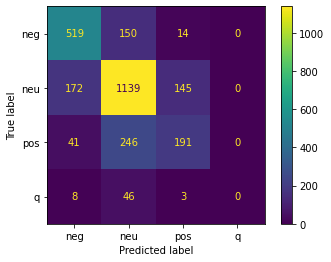

In [87]:
wangchanberta_f1_500 = evaluation("Wangchanberta-500", [ label2id[predict['label']] for predict in predicts[500]] , test_df['label'])

Wangchanberta-1000
              precision    recall  f1-score   support

         neg       0.79      0.72      0.75       683
         neu       0.73      0.81      0.77      1456
         pos       0.61      0.41      0.50       478
           q       0.29      0.67      0.41        57

    accuracy                           0.71      2674
   macro avg       0.61      0.65      0.61      2674
weighted avg       0.72      0.71      0.71      2674



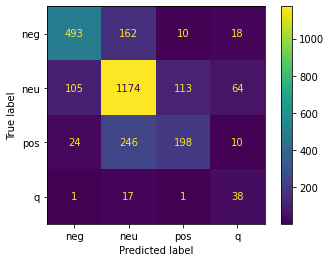

In [88]:
wangchanberta_f1_1000 = evaluation("Wangchanberta-1000", [ label2id[predict['label']] for predict in predicts[1000]] , test_df['label'])

Wangchanberta-1500
              precision    recall  f1-score   support

         neg       0.77      0.82      0.79       683
         neu       0.76      0.83      0.79      1456
         pos       0.64      0.44      0.52       478
           q       0.64      0.40      0.49        57

    accuracy                           0.75      2674
   macro avg       0.70      0.62      0.65      2674
weighted avg       0.74      0.75      0.74      2674



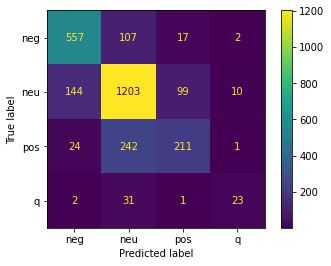

In [89]:
wangchanberta_f1_1500 = evaluation("Wangchanberta-1500", [ label2id[predict['label']] for predict in predicts[1500]], test_df['label'])

## Compare model

In [90]:
micro_f1_score = [wangchanberta_f1_500, wangchanberta_f1_1000, wangchanberta_f1_1500]
score_df = pd.DataFrame({'Model': ['Wangchanberta-500', 'Wangchanberta-1000', 'Wangchanberta-1500'], 'F1 Score': micro_f1_score})
score_df

,Model,F1 Score
0,Wangchanberta-500,0.691473
1,Wangchanberta-1000,0.711668
2,Wangchanberta-1500,0.745699
